In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap
import warnings

/Users/varshameghanakanmuri/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ab_df = pd.read_csv('../Data/Airbnb_Listings.csv')
# ab_df = df_to_list_to_df(ab_df)

In [3]:
pd.options.display.max_columns = None

In [4]:
ab_df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

In [5]:
ab_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4952,https://www.airbnb.com/rooms/4952,20200530151957,2020-05-30,Butterfly Inn - Graceful Living !,Lovely garden setting in a serene and art-fill...,Very comfortable Queen bed and small desk in b...,Lovely garden setting in a serene and art-fill...,none,"Located in Professorville, Palo Alto, one of t...","Housekeeping every Monday, leave your door ope...",Walking distance to Stanford University (30 mi...,"Kitchen, laundry, family/TV room, garden, free...","Welcome and Orientation. Shared kitchen, garde...",No shoes in the house beyond the hall or laund...,NaN,NaN,https://a0.muscache.com/im/pictures/529448/3d7...,NaN,7054,https://www.airbnb.com/users/show/7054,Mei Lin,2009-01-24,"Palo Alto, California, United States","I have lived and worked in Asia, Europe, Austr...",within an hour,100%,98%,t,https://a0.muscache.com/im/users/7054/profile_...,https://a0.muscache.com/im/users/7054/profile_...,Palo Alto,5.0,5.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Palo Alto, CA, United States",Palo Alto,Palo Alto,NaN,Palo Alto,CA,94301,"South Bay, CA","Palo Alto, CA",US,United States,37.43972,-122.15672,t,Villa,Private room,2,2.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,W...",NaN,$90.00,$440.00,"$1,428.00",$0.00,$35.00,1,$45.00,2,365,2,2,365,365,2.0,365.0,2 months ago,t,0,0,0,0,2020-05-30,75,0,2009-08-02,2019-01-12,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,"{""PALO ALTO""}",f,f,moderate,f,f,5,0,5,0,0.57
1,11464,https://www.airbnb.com/rooms/11464,20200530151957,2020-05-31,Deluxe Private Studio-custom int.,Custom built Studio with exquisite design. Rea...,Description A favorite for international corpo...,Custom built Studio with exquisite design. Rea...,none,10 min. to Lucky's and Starbucks at El Camino ...,Pet Policy: - Well Behaved pet up to 25 lb. of...,Public transportation at Homestead and Pomeroy...,Complimentary Wifi-internet + Basic Cable,Available any time for support and problem res...,Can house a couple- bed type is a full size be...,NaN,NaN,https://a0.muscache.com/im/pictures/121321/2c5...,NaN,42458,https://www.airbnb.com/users/show/42458,Emey,2009-09-30,"Mountain View, California, United States",I pride myself on attention to details and cus...,within an hour,100%,90%,f,https://a0.muscach

### Dropping columns containing ids

In [6]:
drop = ["id","last_scraped", "scrape_id", "host_id"]
for col in drop:
    
    ab_df.drop(col, axis = 1, inplace = True )
    


In [7]:
ab_df["price"].head(3)

0    $90.00
1    $85.00
2    $65.00
Name: price, dtype: object

### Converting price from string to float

In [8]:
pattern = r'[^\d\.]'
ab_df["price"] = ab_df["price"].replace({pattern: ''}, regex=True).replace(r'^\s*$', np.nan, regex=True).astype(float)

In [9]:
ab_df["price"].describe()

count     7221.000000
mean       161.287079
std        352.069000
min         10.000000
25%         60.000000
50%        100.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [10]:
# Check the skewness again
from scipy.stats import skew
skewness = skew(ab_df['price'])
print(skewness)

17.904923957648805


### Highly skewed target varaible. We need to deal with it to strategise a split strategy.

In [11]:
# Perform logarithmic transformation
from scipy.stats import skew
ab_df['price'] = np.log1p(ab_df['price'])

# Check the skewness again
skewness = skew(ab_df['price'])
print(skewness)

0.8203765563935524


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define quantiles for stratified sampling
quantiles = ab_df["price"].quantile([0.25, 0.5, 0.75]).values

# Assign each data point to a quantile
quantile_labels = np.zeros(len(ab_df), dtype=int)
quantile_labels[ab_df["price"] <= quantiles[0]] = 0
quantile_labels[(ab_df["price"] > quantiles[0]) & (ab_df["price"] <= quantiles[1])] = 1
quantile_labels[(ab_df["price"] > quantiles[1]) & (ab_df["price"] <= quantiles[2])] = 2
quantile_labels[ab_df["price"] > quantiles[2]] = 3

# Split the data using stratified sampling based on quantiles
dev_data, test_data, train_labels, dev_labels = train_test_split(ab_df, quantile_labels, test_size=0.2, stratify=quantile_labels, random_state=42)


In [13]:
type(ab_df.columns)

pandas.core.indexes.base.Index

In [14]:
# Check the skewness again
skewness = skew(test_data['price'])
print(skewness)

0.7851925668219043


### Preprocessing steps

In [21]:
import pandas as pd
import numpy as np

def get_object_cols(df):
    """Returns a list of columns that have 'object' dtype in the input dataframe."""
    return df.select_dtypes(include='object').columns.tolist()

def get_cols_with_numerical_values(df, object_cols):
    """Returns a list of columns that have numerical values in the input dataframe."""
    pattern = r'^[-+]?[$]?\d+(?:,\d{3})*(\.\d+)?%?|[$]?\d+(?:,\d{3})*[-+]?%?$'
    numerical_cols = []
    for col in object_cols:
        if df[col].str.match(pattern).any():
            numerical_cols.append(col)
    return numerical_cols

def get_needed_num_dollar_cols(numerical_cols):
    
    dollar_and_rate_col = ["host_response_rate", "host_acceptance_rate","zipcode",
                           "weekly_price","monthly_price",
                      "security_deposit", "cleaning_fee", "extra_people"]
    return dollar_and_rate_col

def remove_dollar_and_rate_sign(df, cols):
    """Removes dollar and percentage signs from the input columns in the dataframe."""
    for col in cols:
        df[col] = df[col].str.replace('$', '', regex=True).str.replace('%', '', regex=True)
    
    return df

def convert_to_float(df, cols):
    """Converts the input columns in the dataframe to float dtype."""
    pattern = r'[^\d\.]'
    df[cols] = df[cols].replace({pattern: ''}, regex=True).replace(r'^\s*$', np.nan, regex=True).astype(float)
    
    return df

def get_categorical_cols(dev_df, test_df):
    """Returns a list of columns that have less than or equal to 145 unique values and have object dtype in the input dataframe."""
    data_types = dev_df.dtypes
    cat_cols = data_types[data_types == object].index.tolist()
    rest_cols = data_types[data_types != object].index.tolist()
    categorical_cols = []
    rest_col = []
    for col in cat_cols:
        num_unique = dev_df[col].nunique()
        if num_unique != 1 and num_unique <= 145:
            categorical_cols.append(col)
        else:
#             print(col)
            dev_df.drop(col, axis=1, inplace=True)
            test_df.drop(col, axis=1, inplace=True)
#     print("passed this step")       
    for col in rest_cols:

        num_unique = dev_df[col].nunique()
        if num_unique <= 50:          
            categorical_cols.append(col)  
            rest_col.append(col) 
    return categorical_cols, rest_col

def convert_to_category(df, cols):
    """Converts the input columns in the dataframe to category dtype."""
    for col in cols:
        df[col] = df[col].astype('category')

def get_numerical_cols(dev_df, test_df):
    """Returns a list of columns that have more than 2 unique values and have numerical dtype in the input dataframe."""
    numerical_cols = dev_df.loc[:, dev_df.dtypes != 'category'].columns.tolist()
    for col in numerical_cols:
        num_unique = dev_df[col].nunique()
        if num_unique <= 2:
            dev_df.drop(col, axis=1, inplace=True)
            test_df.drop(col, axis=1, inplace=True)           
    return numerical_cols

def remove_cols_with_high_null_percentage(dev_df,test_df, threshold):
    """Removes columns from the input dataframe that have null percentage greater than the threshold."""
    all_cols = dev_df.columns.tolist()
    for col in all_cols:
        null_percentage = dev_df[col].isnull().mean() * 100
        if null_percentage >= threshold:
            dev_df.drop(col, axis=1, inplace=True)
            test_df.drop(col, axis=1, inplace=True)

def impute_null_values(dev_df, test_df):
    """Imputes null values in numerical and categorical columns less than 75% with the mean or mode respectively."""
    for col in dev_df.columns:
        null_percentage = dev_df[col].isnull().mean() * 100
        if null_percentage < 75:
            if pd.api.types.is_numeric_dtype(dev_df[col]):
                dev_df[col].fillna(dev_df[col].mean(), inplace=True)
                test_df[col].fillna(dev_df[col].mean(), inplace=True)
            else:
                dev_df[col].fillna(dev_df[col].mode()[0], inplace=True)
                test_df[col].fillna(dev_df[col].mode()[0], inplace=True)

### The strategy for handling outliers in numerical columns is to replace values above the 99th percentile with the 99th percentile value. This is done using the quantile() method to calculate the 99th percentile and then using np.where() to replace any values above this percentile with the 99th percentile value.

### For categorical columns, the strategy is to replace outliers with the most common category. This is done by calculating the value counts of each category using the value_counts() method and checking if the most common category has a frequency of over 90%. If it does, any categories that are not the most common are replaced with the most common category using np.where().

In [22]:
import pandas as pd
import numpy as np

def handle_outliers(df, dev_df, test_df, numerical_cols, categorical_cols):
    """
    Handles outliers in both numerical and categorical columns.
    
    Replaces numerical outliers with the 99th percentile value and categorical outliers
    with the most common category.
    
    Args:
        dataframe: Input pandas DataFrame.
    
    Returns:
        The input DataFrame with outliers handled.
    """
    
    # Check numerical columns for outliers
    for col in numerical_cols:
        q99 = df[col].quantile(0.99)
        df[col] = np.where(df[col] > q99, q99, df[col])
        dev_df[col] = np.where(dev_df[col] > q99, q99, dev_df[col])
        test_df[col] = np.where(test_df[col] > q99, q99, test_df[col])
    
    # Check categorical columns for outliers
    for col in categorical_cols:
        vc = df[col].value_counts(normalize=True, dropna=False)
        if len(vc) > 1 and vc.iloc[0] > 0.9:
            df[col] = np.where(df[col].isin([vc.index[0]]), df[col], vc.index[0])
            dev_df[col] = np.where(dev_df[col].isin([vc.index[0]]), dev_df[col], vc.index[0])
            test_df[col] = np.where(test_df[col].isin([vc.index[0]]), test_df[col], vc.index[0])
 
    return df, dev_df, test_df

In [23]:
from sklearn.preprocessing import StandardScaler
def scale(dev_df, test_df):

    # Fit the scaler on the training set
    scaler = StandardScaler()
    dev_df = scaler.fit_transform(dev_df)

    # Use the same scaler to transform the dev and test set
    test_df = scaler.transform(test_df)
    

    return dev_df, test_df

In [24]:
def data_preprocess_transforms(df):
    object_cols = get_object_cols(df)
    numerical_cols = get_cols_with_numerical_values(df, object_cols)
    dollar_and_rate_col= get_needed_num_dollar_cols(numerical_cols)
    remove_dollar_and_rate_sign(df, dollar_and_rate_col)
    convert_to_float(df, dollar_and_rate_col)
    return df

In [25]:
def data_preprocess(dev_df, test_df):
    object_cols = get_object_cols(dev_df)
    numerical_cols = get_cols_with_numerical_values(dev_df, object_cols)
    dollar_and_rate_col= get_needed_num_dollar_cols(numerical_cols)
    remove_dollar_and_rate_sign(dev_df, dollar_and_rate_col)
    convert_to_float(dev_df, dollar_and_rate_col)
    data_preprocess_transforms(test_df)
        
    remove_cols_with_high_null_percentage(dev_df,test_df, 75)
    fix_null = impute_null_values(dev_df,test_df)
    categorical_cols,rest_col = get_categorical_cols(dev_df,test_df)
    convert_to_category(dev_df, categorical_cols)
    convert_to_category(test_df, categorical_cols)
    
    numerical_cols = get_numerical_cols(dev_df,test_df)
    scale(dev_df[numerical_cols],test_df[numerical_cols])

    return dev_df,test_df, categorical_cols , numerical_cols, rest_col 

In [26]:
dev_data, test_data, categorical_cols, numerical_cols, rest_col  = data_preprocess(dev_data, test_data)


In [27]:
print("dev", dev_data.shape)
print("test", test_data.shape)

dev (5776, 65)
test (1445, 65)


### Performing encoding of categorical variables

In [28]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

def encode_ordinal(dev_df, test_df, col):
    """Encode ordinal column using OrdinalEncoder from scikit-learn"""
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dev_df[[col]] = encoder.fit_transform(dev_df[[col]])
    test_df[[col]] = encoder.transform(test_df[[col]])
    return dev_df, test_df

def encode_normal(dev_df, test_df, col):
    """Encode normal category column using OneHotEncoder from scikit-learn"""
    encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    encoder.fit(dev_df[[col]])
    encoded_dev_col = encoder.transform(dev_df[[col]])
    encoded_test_col = encoder.transform(test_df[[col]])
    categories = encoder.get_feature_names_out([col])
    dev_df = dev_df.join(pd.DataFrame(encoded_dev_col, columns=categories, index=dev_df.index))
    test_df = test_df.join(pd.DataFrame(encoded_test_col, columns=categories, index=test_df.index))
    dev_df.drop(columns=[col], inplace=True)
    test_df.drop(columns=[col], inplace=True)
    return dev_df, test_df

def encode_columns(dev_df, test_df):
    """Encode all categorical columns in the dataframe"""
    ordinal_cols = ['host_response_time', 'bathrooms', 'bedrooms', 'beds']
    normal_cols = ['host_is_superhost', 'host_neighbourhood', 'host_has_profile_pic', 
                   'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed',
                   'city', 'state', 'market', 'smart_location', 'is_location_exact', 'property_type',
                   'room_type', 'bed_type', 'calendar_updated', 'calendar_last_scraped', 
                   'jurisdiction_names', 'instant_bookable', 'cancellation_policy', 
                   'require_guest_profile_picture', 'require_guest_phone_verification', 
                   'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                   'review_scores_communication', 'review_scores_location', 'review_scores_value',
                   'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                   'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
    for col in ordinal_cols:
        dev_df, test_df = encode_ordinal(dev_df, test_df, col)
    for col in normal_cols:
        dev_df, test_df = encode_normal(dev_df, test_df, col)
    return dev_df, test_df

dev_data, test_data = encode_columns(dev_data, test_data)


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [29]:
dev_data.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'zipcode',
       'latitude', 'longitude', 'accommodates', 'bathrooms',
       ...
       'calculated_host_listings_count_shared_rooms_5',
       'calculated_host_listings_count_shared_rooms_6',
       'calculated_host_listings_count_shared_rooms_8',
       'calculated_host_listings_count_shared_rooms_10',
       'calculated_host_listings_count_shared_rooms_11',
       'calculated_host_listings_count_shared_rooms_12',
       'calculated_host_listings_count_shared_rooms_13',
       'calculated_host_listings_count_shared_rooms_18',
       'calculated_host_listings_count_shared_rooms_39',
       'calculated_host_listings_count_shared_rooms_48'],
      dtype='object', length=582)

### Feature selection and dropping highly correlated columns

In [30]:
def feature_selection(dev_df, test_df, threshold=0.9):
    corr_matrix = dev_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    dev_df = dev_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    print(to_drop)
    return dev_df, test_df

In [31]:
dev_data, test_data = feature_selection(dev_data, test_data, threshold=0.9)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


['host_total_listings_count', 'minimum_minimum_nights', 'minimum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_90', 'host_neighbourhood_Potrero Hill', 'neighbourhood_Chapman/Morse', 'neighbourhood_College Park', 'neighbourhood_Cupertino', 'neighbourhood_Delmas Park', 'neighbourhood_Forest/Pruneridge', 'neighbourhood_Los Altos Hills', 'neighbourhood_Mountain View', 'neighbourhood_Santa Clara', 'neighbourhood_Sunnyvale', 'neighbourhood_Vermont/McKendrie', 'neighbourhood_cleansed_Cupertino', 'neighbourhood_cleansed_Los Altos', 'neighbourhood_cleansed_Los Altos Hills', 'neighbourhood_cleansed_Milpitas', 'neighbourhood_cleansed_Monte Sereno', 'neighbourhood_cleansed_Mountain View', 'neighbourhood_cleansed_Palo Alto', 'neighbourhood_cleansed_San Jose', 'neighbourhood_cleansed_Santa Clara', 'neighbourhood_cleansed_Saratoga', 'neighbourhood_cleansed_Sunnyvale', 'city_Cupertino', 'city_Danville ', 'city_Fremont', 'city_Gilroy', 'city_Hollister', 'city_Los Al

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [32]:
print("Final features shape of dev set", dev_data.shape)
print("Final features shape of test set", test_data.shape)

Final features shape of dev set (5776, 460)
Final features shape of test set (1445, 460)


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Separate features and target variable for development data
X_dev = dev_data.drop(columns=['price'])
y_dev = dev_data['price']

# Separate features and target variable for test data
X_test = test_data.drop(columns=['price'])
y_test = test_data['price']

### Decision Tree Regressor

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# train the model
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_dev, y_dev)

# evaluate the model on dev set
y_pred_dev = regressor.predict(X_dev)
mse_dev = mean_squared_error(y_dev, y_pred_dev)
mae_dev = mean_absolute_error(y_dev, y_pred_dev)
r2_dev = r2_score(y_dev, y_pred_dev)

# evaluate the model on test set
y_pred_test = regressor.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# print the evaluation metrics
print("Evaluation metrics on dev set:")
print(f"Mean Squared Error: {mse_dev}")
print(f"Mean Absolute Error: {mae_dev}")
print(f"R-squared: {r2_dev}")
print("\n")
print("Evaluation metrics on test set:")
print(f"Mean Squared Error: {mse_test}")
print(f"Mean Absolute Error: {mae_test}")
print(f"R-squared: {r2_test}")


Evaluation metrics on dev set:
Mean Squared Error: 8.023818937280894e-33
Mean Absolute Error: 1.0994590894833614e-17
R-squared: 1.0


Evaluation metrics on test set:
Mean Squared Error: 0.2427225656587119
Mean Absolute Error: 0.3327115166873951
R-squared: 0.5491812393753097


### Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a Random Forest Regressor object
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_dev, y_dev)

# Predict on the dev and test sets
y_dev_pred = rf_model.predict(X_dev)
y_test_pred = rf_model.predict(X_test)

# Calculate evaluation metrics on dev set
mse_dev = mean_squared_error(y_dev, y_dev_pred)
mae_dev = mean_absolute_error(y_dev, y_dev_pred)
r2_dev = r2_score(y_dev, y_dev_pred)

print("Evaluation metrics on dev set:")
print("Mean Squared Error: {}".format(mse_dev))
print("Mean Absolute Error: {}".format(mae_dev))
print("R-squared: {}".format(r2_dev))

# Calculate evaluation metrics on test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nEvaluation metrics on test set:")
print("Mean Squared Error: {}".format(mse_test))
print("Mean Absolute Error: {}".format(mae_test))
print("R-squared: {}".format(r2_test))


Evaluation metrics on dev set:
Mean Squared Error: 0.021100410766331134
Mean Absolute Error: 0.09402183595102637
R-squared: 0.9647687568539686

Evaluation metrics on test set:
Mean Squared Error: 0.10805873023135466
Mean Absolute Error: 0.22946957372229476
R-squared: 0.7992980063251545


### Performing RandomSearchCV to find best hyperparameters for Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a Random Forest Regressor object
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2", None]
}

# Create a RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object on the training data
rf_random.fit(X_dev, y_dev)

# Print the best hyperparameters
print("Best Hyperparameters: ", rf_random.best_params_)

# Predict on the dev and test sets using the best estimator
best_rf_model = rf_random.best_estimator_
y_dev_pred = best_rf_model.predict(X_dev)
y_test_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics on dev set
mse_dev = mean_squared_error(y_dev, y_dev_pred)
mae_dev = mean_absolute_error(y_dev, y_dev_pred)
r2_dev = r2_score(y_dev, y_dev_pred)

print("\nEvaluation metrics on dev set:")
print("Mean Squared Error: {}".format(mse_dev))
print("Mean Absolute Error: {}".format(mae_dev))
print("R-squared: {}".format(r2_dev))

# Calculate evaluation metrics on test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nEvaluation metrics on test set:")
print("Mean Squared Error: {}".format(mse_test))
print("Mean Absolute Error: {}".format(mae_test))
print("R-squared: {}".format(r2_test))


Best Hyperparameters:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}

Evaluation metrics on dev set:
Mean Squared Error: 0.051930373539472635
Mean Absolute Error: 0.1619618990963084
R-squared: 0.9132921326937979

Evaluation metrics on test set:
Mean Squared Error: 0.11124592119612675
Mean Absolute Error: 0.23686639696744793
R-squared: 0.7933783034054306


In [37]:
## YOUR CODE HERE
# Get feature importances from the trained RF model
importances = rf_random.best_estimator_.feature_importances_

# Create a dictionary of feature importance scores with their corresponding column names
feature_importances = dict(zip(X_dev.columns, importances))

# Sort the features by their importance scores (descending order)
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print the top 3 most important features
print("Top 3 most important features:")
for feature, importance in sorted_features[:3]:
    print(f"{feature}: {importance}")


Top 3 most important features:
bedrooms: 0.3673363328353575
cleaning_fee: 0.12525070626037124
room_type_Private room: 0.05795515011702611


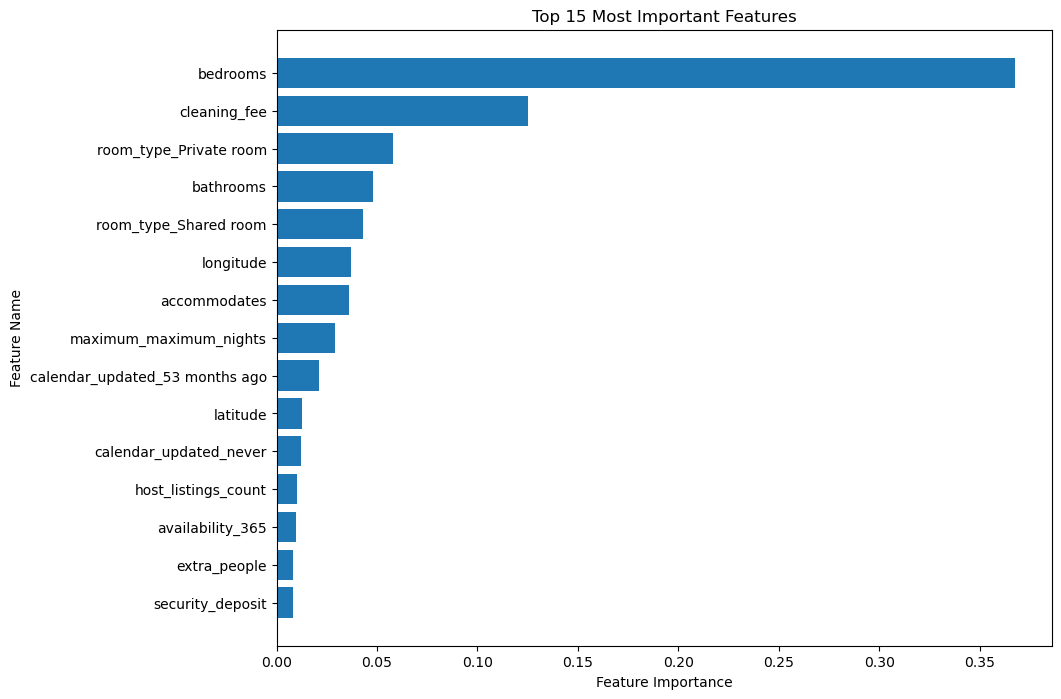

In [38]:
import matplotlib.pyplot as plt

# Get feature importances from the trained RF model
importances = rf_random.best_estimator_.feature_importances_

# Create a dictionary of feature importance scores with their corresponding column names
feature_importances = dict(zip(X_dev.columns, importances))

# Sort the features by their importance scores (descending order)
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract the top 15 features and their importances
top_features = sorted_features[:15][::-1]
feature_names = [x[0] for x in top_features]
feature_importances = [x[1] for x in top_features]

# Create a horizontal bar chart to display the feature importances
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, feature_importances)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Name')
ax.set_title('Top 15 Most Important Features')
plt.show()


## CatBoost and Neural Networks

In [39]:
categorial_features = []
# CatBoost algorithm requires all categorical columns to be converted to string
# Hence making a copy
X_dev_catboost = X_dev.copy()
X_test_catboost = X_test.copy()

for col in X_dev.columns:
    if(X_dev[col].dtypes=='category'):
        X_dev_catboost[col] = X_dev_catboost[col].astype('str')
        X_test_catboost[col] = X_test_catboost[col].astype('str')
        categorial_features.append(col)

In [40]:
categorial_features

['host_response_rate',
 'accommodates',
 'guests_included',
 'availability_30',
 'review_scores_rating']

In [41]:
from catboost import CatBoostRegressor

# Create a CatBoost Regressor object
cat_model = CatBoostRegressor(random_seed=42, verbose=0)

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'iterations': [100, 200, 500],
    'learning_rate': np.logspace(-4, 0, 5),
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 1, 5, 10],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'task_type': ['CPU']
}

# Create a RandomizedSearchCV object
cat_random = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object on the training data
cat_random.fit(X_dev_catboost, y_dev, cat_features=categorial_features)

# Print the best hyperparameters
print("Best Hyperparameters: ", cat_random.best_params_)

# Predict on the dev and test sets using the best estimator
best_cat_model = cat_random.best_estimator_
y_dev_pred = best_cat_model.predict(X_dev_catboost)
y_test_pred = best_cat_model.predict(X_test_catboost)

# Calculate evaluation metrics on dev set
mse_dev = mean_squared_error(y_dev, y_dev_pred)
mae_dev = mean_absolute_error(y_dev, y_dev_pred)
r2_dev = r2_score(y_dev, y_dev_pred)

print("\nEvaluation metrics on dev set:")
print("Mean Squared Error: {}".format(mse_dev))
print("Mean Absolute Error: {}".format(mae_dev))
print("R-squared: {}".format(r2_dev))


# Calculate evaluation metrics on test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nEvaluation metrics on test set:")
print("Mean Squared Error: {}".format(mse_test))
print("Mean Absolute Error: {}".format(mae_test))
print("R-squared: {}".format(r2_test))


Best Hyperparameters:  {'task_type': 'CPU', 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'grow_policy': 'Lossguide', 'depth': 4, 'border_count': 32, 'bagging_temperature': 5}

Evaluation metrics on dev set:
Mean Squared Error: 0.10916697139130532
Mean Absolute Error: 0.23599229782900183
R-squared: 0.8177244909971164

Evaluation metrics on test set:
Mean Squared Error: 0.10741064378524422
Mean Absolute Error: 0.24003929568092744
R-squared: 0.8005017243545032


In [42]:
cat_final = cat_random.best_estimator_
cat_final.fit(X_dev_catboost, y_dev)

feat_importance = cat_final.get_feature_importance()

feature_names = list(X_dev_catboost.columns)

feat_imps_cat = pd.DataFrame(feat_importance, index = \
            feature_names, columns = ['importance_values'])


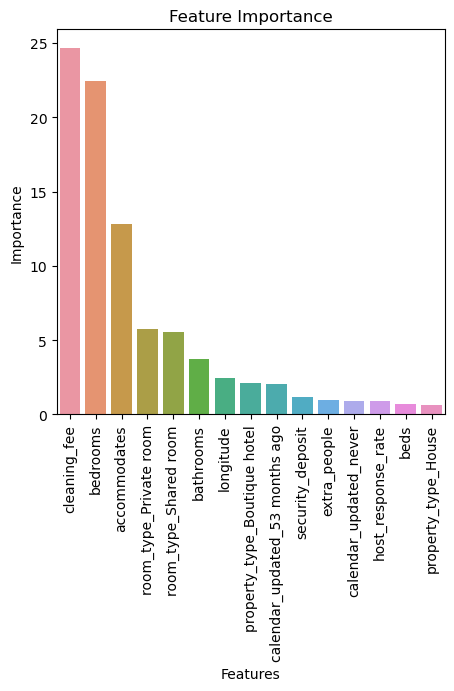

In [43]:
feat_imps_cat = feat_imps_cat.sort_values('importance_values', ascending=False)
fig, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=feat_imps_cat.index[0:15], y=feat_imps_cat['importance_values'][0:15])

ax.set_title("Feature Importance")
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

In [44]:
## Preprocesing for Neural Networks

In [45]:
X_dev_NN = X_dev.copy()
X_test_NN = X_test.copy()
for col in categorial_features:
    X_dev_NN[col] = X_dev_NN[col].astype('float')
    X_test_NN[col] = X_test_NN[col].astype('float')

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_dev_NN = scaler.fit_transform(X_dev_NN)   
X_test_NN = scaler.transform(X_test_NN)

In [47]:
from sklearn.neural_network import MLPRegressor


# Create an MLP Regressor object
mlp = MLPRegressor(random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    "hidden_layer_sizes": [(500,), (1024,512), (512,512), (512, 256), (2048, 1024,512)],
    "activation": ['relu', 'tanh', 'logistic'],
    "solver": ['adam','sgd'],
    "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
}

# Create a RandomizedSearchCV object
mlp_random = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object on the training data
mlp_random.fit(X_dev_NN, y_dev)

# Print the best hyperparameters
print("Best Hyperparameters: ", mlp_random.best_params_)

# Predict on the dev and test sets using the best estimator
best_mlp_model = mlp_random.best_estimator_
y_dev_pred = best_mlp_model.predict(X_dev_NN)
y_test_pred = best_mlp_model.predict(X_test_NN)


# Calculate evaluation metrics on dev set
mse_dev = mean_squared_error(y_dev, y_dev_pred)
mae_dev = mean_absolute_error(y_dev, y_dev_pred)
r2_dev = r2_score(y_dev, y_dev_pred)

print("\nEvaluation metrics on dev set:")
print("Mean Squared Error: {}".format(mse_dev))
print("Mean Absolute Error: {}".format(mae_dev))
print("R-squared: {}".format(r2_dev))


# Calculate evaluation metrics on test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nEvaluation metrics on test set:")
print("Mean Squared Error: {}".format(mse_test))
print("Mean Absolute Error: {}".format(mae_test))
print("R-squared: {}".format(r2_test))

/Users/varshameghanakanmuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/varshameghanakanmuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/varshameghanakanmuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/varshameghanakanmuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

Best Hyperparameters:  {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (512, 512), 'alpha': 0.01, 'activation': 'logistic'}

Evaluation metrics on dev set:
Mean Squared Error: 0.1503883904765663
Mean Absolute Error: 0.2706488734863528
R-squared: 0.7488973077398775

Evaluation metrics on test set:
Mean Squared Error: 0.12740239175088927
Mean Absolute Error: 0.266134670261379
R-squared: 0.763370215728042


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [48]:
nn_final = mlp_random.best_estimator_
nn_final.fit(X_dev_NN, y_dev)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPRegressor(activation='logistic', alpha=0.01, hidden_layer_sizes=(512, 512),
             learning_rate='adaptive', random_state=42, solver='sgd')

In [49]:
# sample_size is a parameter which can be used to set number of data points used in the SHAP analysis.
# setting sample_size to a higher value gives better explainability, but takes lot of time to execute.
sample_size = 100
tmp = X_test_NN[0:sample_size]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(nn_final.predict, tmp)
    shap_values = explainer.shap_values(tmp)

100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


### Shap summary plots for 100 data samples.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


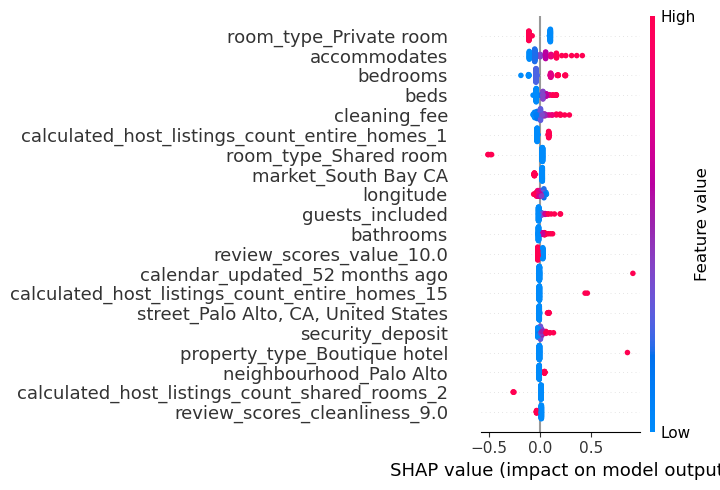

In [50]:
shap.summary_plot(shap_values, tmp, feature_names = feature_names, plot_size=[7,5])

In [51]:
sample_size = 300
tmp = X_test_NN[0:sample_size]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    explainer = shap.KernelExplainer(nn_final.predict, tmp)
    shap_values = explainer.shap_values(tmp)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [1:25:20<00:00, 17.07s/it]


### Shap summary plots for 300 data samples.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


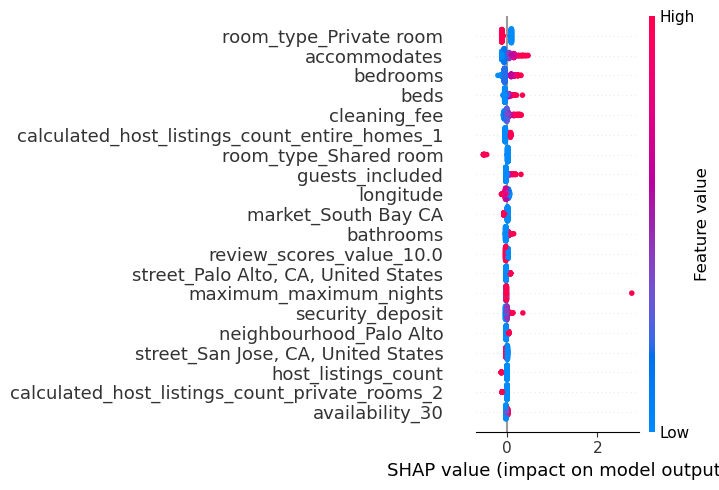

In [52]:
shap.summary_plot(shap_values, tmp, feature_names = feature_names, plot_size=[7,5])